# imports

In [ ]:
import folium
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import to_hex
import pandas as pd
import numpy as np
import torch
import math
import torch.nn as nn
from tqdm import tqdm
from torch.nn import LayerNorm
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from utils import *
import torch.nn.functional as F
import json
from geojson import Feature, FeatureCollection, LineString
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm
import optuna
from optuna.trial import Trial
import numpy as np
from kan import *
import kan
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from utils import load_inp_outp, create_network_df, prepare_network_data, load_inp_outp_cap
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from efficient_kan import KAN
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pickle
import os

# loading data

In [ ]:
class TrafficDataset(Dataset):
    def __init__(self, X_data, capacity_data, free_flow_data, flows_data):
        self.data = []
        self.flows_mean = flows_data.mean()
        self.flows_std = flows_data.std()
        self.capacity_mean = capacity_data.mean()
        self.capacity_std = capacity_data.std() + 1e-8
        self.free_flow_mean = free_flow_data.mean()
        self.free_flow_std = free_flow_data.std() + 1e-8

        for x, cap, fft, fl in zip(X_data, capacity_data, free_flow_data, flows_data):
            od_matrix = x[:, :-2]
            coordinates = x[:, -2:]

            od_mean = od_matrix.mean()
            od_std = od_matrix.std() + 1e-8
            od_matrix_norm = (od_matrix - od_mean) / od_std

            coord_mean = coordinates.mean(axis=0)
            coord_std = coordinates.std(axis=0) + 1e-8
            coordinates_norm = (coordinates - coord_mean) / coord_std

            x_normalized = np.concatenate([od_matrix_norm, coordinates], axis=1)

            cap = (cap - self.capacity_mean) / self.capacity_std
            fft = (fft - self.free_flow_mean) / self.free_flow_std
            #fl = (fl - self.flows_mean) / self.flows_std

            self.data.append({
                'od_matrix': torch.FloatTensor(od_matrix_norm),
                'od': torch.FloatTensor(od_matrix),
                'coordinates': torch.FloatTensor(coordinates),
                'coordinates_norm': torch.FloatTensor(coordinates_norm),
                'capacity': torch.FloatTensor(cap),
                'free_flow': torch.FloatTensor(fft),
                'flows': torch.FloatTensor(fl),
                'x_normalized': torch.FloatTensor(x_normalized)
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        real_adj_mask = (item['capacity'] > 0).float()
        virtual_adj = item['od_matrix'].abs()

        edge_features = torch.stack([
            item['capacity'],
            item['free_flow']
        ], dim=-1)

        agg_demand = item['od_matrix'].sum(dim=1, keepdim=True)
        node_features = torch.cat([item['coordinates'], agg_demand], dim=1)

        return {
            'node_features': node_features,
            'coordinates': item['coordinates'],
            'real_adj_mask': real_adj_mask,
            'edge_features': edge_features,
            'capacity': item['capacity'],
            'virtual_adj': virtual_adj,
            'target_flows': item['flows'],
            'x_normalized': item['x_normalized'],
            'od_matrix': item['od']
        }

    def inverse_transform_flows(self, normalized_flows):
        print(self.flows_std, self.flows_mean)
        if isinstance(normalized_flows, torch.Tensor):
            return normalized_flows * self.flows_std + self.flows_mean
        else:
            return normalized_flows * self.flows_std.numpy() + self.flows_mean.numpy()

In [ ]:
def load_dataset(network_name='SiouxFalls', file_path='/home/podozerovapo/traffic_assignment/data/sioux', network_type='uncongested', train_rate=0.8, node=False):
    node_coords = pd.read_csv(file_path + "/" + network_name + "_node.tntp", sep='\t')
    node_coords_arr = np.array(node_coords[['X', 'Y']])

    sioux = create_network_df(network_name=network_name)
    free_flow_times, capacities = prepare_network_data(sioux)

    directory = os.path.join(file_path, network_type)

    inputs = []
    outputs = []
    metadata = []

    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".pkl"):
            filepath = os.path.join(directory, filename)
            
            with open(filepath, 'rb') as f:
                data_pair = pickle.load(f)
                
                inputs.append(data_pair['input'])
                outputs.append(data_pair['output'])
                metadata.append(data_pair.get('metadata', None))

    global output_matrices 
    
    input_matrices = np.array(inputs)  # [num_samples, num_nodes, num_nodes]
    output_matrices = np.array(outputs)  # [num_samples, num_nodes, num_nodes]
    
    coords_for_concat = np.repeat(np.expand_dims(node_coords_arr, 0), repeats=input_matrices.shape[0],axis=0)

    X = np.concatenate([input_matrices, coords_for_concat], axis=2)
    #X = input_matrices
    if len(capacities.shape) == 2: 
        capacities = np.repeat(np.expand_dims(capacities, 0), axis=0, repeats=input_matrices.shape[0])
    if len(free_flow_times.shape) == 2:
        free_flow_times = np.repeat(np.expand_dims(free_flow_times, 0), axis=0, repeats=input_matrices.shape[0])
    
    node_num = capacities.shape[-1]
    
    full_dataset = TrafficDataset(X, capacities, free_flow_times, output_matrices)
    train_size = int(train_rate * len(full_dataset))
    val_size = int((len(full_dataset) - train_size) * 0.8)
    test_size = len(full_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = load_dataset(network_name='SiouxFalls', file_path='/home/podozerovapo/traffic_assignment/data/sioux')
#train_dataset_ema, val_dataset_ema, test_dataset_ema = load_dataset(network_name='EMA', file_path='/home/podozerovapo/traffic_assignment/data/EMA')

# train_loader_ema = DataLoader(train_dataset_ema, batch_size=64, shuffle=True, num_workers=4)
# val_loader_ema = DataLoader(val_dataset_ema, batch_size=64, shuffle=False, num_workers=4)
# test_loader_ema = DataLoader(test_dataset_ema, batch_size=1, shuffle=False, num_workers=4)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# model

In [ ]:
class FeatureEmbedding(nn.Module):
    def __init__(self, input_size, embedding_size=32):
        super(FeatureEmbedding, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, embedding_size),
            nn.ReLU()
        )
    def forward(self, x):
        return self.network(x)

class SharedEncoderComponents(nn.Module):
    def __init__(self, node_feat_size, n_heads, dropout=0.1):
        super().__init__()
        self.node_feat_size = node_feat_size
        self.n_heads = n_heads
        self.head_dim = node_feat_size // n_heads
        
        self.q_linear = nn.Linear(node_feat_size, node_feat_size)
        self.k_linear = nn.Linear(node_feat_size, node_feat_size)
        self.v_linear = nn.Linear(node_feat_size, node_feat_size)
        
        self.out_ffn = nn.Sequential(
            nn.Linear(node_feat_size, node_feat_size),
            nn.ReLU(),
            nn.Linear(node_feat_size, node_feat_size)
        )
        
        self.layer_norm = nn.LayerNorm(node_feat_size)
        self.dropout = nn.Dropout(dropout)

class VEncoderLayer(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size, n_heads, dropout=0.1):
        super().__init__()
        self.shared = SharedEncoderComponents(node_feat_size, n_heads, dropout)
        self.n_heads = n_heads
        self.head_dim = node_feat_size // n_heads
        self.edge_weight_ffn = nn.Sequential(
            nn.Linear(2 * node_feat_size, edge_feat_size),
            nn.ReLU(),
            nn.Linear(edge_feat_size, n_heads),
            nn.Sigmoid()
        )
        
        self.ffn = nn.Sequential(
            nn.Linear(node_feat_size, node_feat_size * 2),
            nn.ReLU(),
            nn.Linear(node_feat_size * 2, node_feat_size),
            nn.Dropout(dropout)
        )
        
    def forward(self, x, adj_mask):
        batch_size, num_nodes, _ = x.size()

        q = self.shared.q_linear(x).view(batch_size, num_nodes, self.n_heads, self.head_dim)
        k = self.shared.k_linear(x).view(batch_size, num_nodes, self.n_heads, self.head_dim)
        v = self.shared.v_linear(x).view(batch_size, num_nodes, self.n_heads, self.head_dim)
        
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        src_nodes = x.unsqueeze(2).expand(-1, -1, num_nodes, -1)
        dst_nodes = x.unsqueeze(1).expand(-1, num_nodes, -1, -1)
        node_pairs = torch.cat([src_nodes, dst_nodes], dim=-1)
        beta = self.edge_weight_ffn(node_pairs).permute(0, 3, 1, 2)
        
        adj_mask = adj_mask.unsqueeze(1)
        scores = scores * adj_mask * beta
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.shared.dropout(attn_weights)
        
        output = torch.matmul(attn_weights, v)
        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, num_nodes, self.shared.node_feat_size)
        
        output = self.shared.out_ffn(output)
        output = self.shared.dropout(output)
        output = self.shared.layer_norm(x + output)
        
        ffn_output = self.ffn(output)
        output = self.shared.layer_norm(output + ffn_output)
        
        return output

class REncoderLayer(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size, n_heads, dropout=0.1):
        super().__init__()
        self.shared = SharedEncoderComponents(node_feat_size, n_heads, dropout)
        self.n_heads = n_heads
        self.head_dim = node_feat_size // n_heads
        self.edge_feat_transform = nn.Linear(edge_feat_size, n_heads)
        
        self.ffn = nn.Sequential(
            nn.Linear(node_feat_size, node_feat_size * 2),
            nn.ReLU(),
            nn.Linear(node_feat_size * 2, node_feat_size),
            nn.Dropout(dropout)
        )
        
    def forward(self, x, adj_mask, edge_features):
        batch_size, num_nodes, _ = x.size()
        
        q = self.shared.q_linear(x).view(batch_size, num_nodes, self.n_heads, self.head_dim)
        k = self.shared.k_linear(x).view(batch_size, num_nodes, self.n_heads, self.head_dim)
        v = self.shared.v_linear(x).view(batch_size, num_nodes, self.n_heads, self.head_dim)
        
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        edge_weights = self.edge_feat_transform(edge_features).permute(0, 3, 1, 2)
    
        adj_mask = adj_mask.unsqueeze(1)
        scores = scores * adj_mask * torch.sigmoid(edge_weights)
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.shared.dropout(attn_weights)
        
        output = torch.matmul(attn_weights, v)
        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, num_nodes, self.shared.node_feat_size)
        
        output = self.shared.out_ffn(output)
        output = self.shared.dropout(output)
        output = self.shared.layer_norm(x + output)
        
        ffn_output = self.ffn(output)
        output = self.shared.layer_norm(output + ffn_output)
        
        return output

class VEncoder(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size, n_layers=3, n_heads=4, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            VEncoderLayer(node_feat_size, edge_feat_size, n_heads, dropout)
            for _ in range(n_layers)
        ])
        
    def forward(self, x, v_adj_mask):
        for layer in self.layers:
            x = layer(x, v_adj_mask)
        return x

class REncoder(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size, n_layers=3, n_heads=4, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            REncoderLayer(node_feat_size, edge_feat_size, n_heads, dropout)
            for _ in range(n_layers)
        ])
        
    def forward(self, x, adj_mask, edge_features):
        for layer in self.layers:
            x = layer(x, adj_mask, edge_features)
        return x

class DualGraphEncoder(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size,
                 v_layers=3, r_layers=3, n_heads=8, dropout=0.1):
        super().__init__()
        self.vencoder = VEncoder(node_feat_size, edge_feat_size, v_layers, n_heads, dropout)
        self.rencoder = REncoder(node_feat_size, edge_feat_size, r_layers, n_heads, dropout)

    def forward(self, node_features, real_adj_mask, virtual_adj_mask, edge_features):
        v_encoded = self.vencoder(node_features, virtual_adj_mask)
        r_encoded = self.rencoder(node_features, real_adj_mask, edge_features)
        return v_encoded, r_encoded

class TrafficAssignmentModel(nn.Module):
    def __init__(self, num_nodes, node_feat_size=32, edge_feat_size=2,
                 v_layers=2, r_layers=2, n_heads=8, dropout=0.1):
        super().__init__()
        
        self.feature_preprocessor = FeatureEmbedding(input_size=num_nodes + 2, embedding_size=node_feat_size)
        
        self.dual_encoder = DualGraphEncoder(node_feat_size, edge_feat_size, 
                                           v_layers, r_layers, n_heads, dropout)
        
        self.flow_predictor = nn.Sequential(
            nn.Linear(4 * node_feat_size, node_feat_size),
            nn.ReLU(),
            nn.Linear(node_feat_size, 1),
            nn.ReLU()
        )

    def forward(self, node_features, real_adj_mask, virt_adj_mask, edge_features):
        node_features = self.feature_preprocessor(node_features)
        v_encoded, r_encoded = self.dual_encoder(node_features, real_adj_mask, virt_adj_mask, edge_features)
        combined = torch.cat([v_encoded, r_encoded], dim=-1)
        src_nodes = combined.unsqueeze(2).expand(-1, -1, combined.size(1), -1)
        dst_nodes = combined.unsqueeze(1).expand(-1, combined.size(1), -1, -1)
        pair_features = torch.cat([src_nodes, dst_nodes], dim=-1)

        flows = self.flow_predictor(pair_features).squeeze(-1)
        flows = flows * real_adj_mask
        
        return flows

# training

# other

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=100, lr=1e-3, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
    criterion = nn.MSELoss()

    best_loss = float('inf')
    epochs_no_improve = 0
    train_history = []
    val_history = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            node_feat = batch['x_normalized'].to(device)
            real_mask = batch['real_adj_mask'].to(device)
            edge_feat = batch['edge_features'].to(device)
            virt_adj = batch['virtual_adj'].to(device)
            targets = batch['target_flows'].to(device)
            capacities = batch['capacity'].to(device)
            od_matrix = batch['od_matrix'].to(device)

            optimizer.zero_grad()
            outputs = model(node_feat, real_mask, virt_adj, edge_feat)
            
            mask = real_mask.bool()
            pred_flows = outputs[mask]
            true_flows = targets[mask]
            true_capacities = capacities[mask]
            
            alpha_true = true_flows / true_capacities
            alpha_pred = pred_flows / true_capacities
            
            L_alpha = torch.mean(torch.abs(alpha_true - alpha_pred))
            L_f = torch.mean(torch.abs(true_flows - pred_flows))
            
            # incoming_flows = torch.einsum('bijk,bik->bij', outputs, real_mask.float())
            # outgoing_flows = torch.einsum('bijk,bkj->bij', outputs, real_mask.float())
            
            delta_f = torch.zeros_like(node_feat[:,:,0])
            od_send = torch.sum(od_matrix, dim=2)
            od_receive = torch.sum(od_matrix, dim=1)
            delta_f = od_receive - od_send
            
            #L_c = torch.mean(torch.abs(incoming_flows - outgoing_flows - delta_f.unsqueeze(-1)))
            L_c = 0
            
            w_alpha, w_f, w_c = 1, 0.005, 0.05
            loss = w_alpha * L_alpha + w_f * L_f + w_c * L_c

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item() / train_loader.batch_size

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                node_feat = batch['x_normalized'].to(device)
                real_mask = batch['real_adj_mask'].to(device)
                edge_feat = batch['edge_features'].to(device)
                virt_adj = batch['virtual_adj'].to(device)
                targets = batch['target_flows'].to(device)
                capacities = batch['capacity'].to(device)
                od_matrix = batch['od_matrix'].to(device)

                outputs = model(node_feat, real_mask, virt_adj, edge_feat)
                #print(real_mask.shape)
                mask = real_mask.bool()
                pred_flows = outputs[mask]
                true_flows = targets[mask]
                true_capacities = capacities[mask]
                
                alpha_true = true_flows / true_capacities
                alpha_pred = pred_flows / true_capacities
                
                L_alpha = torch.mean(torch.abs(alpha_true - alpha_pred))
                L_f = torch.mean(torch.abs(true_flows - pred_flows))
                
                # incoming_flows = torch.einsum('bijk,bik->bij', outputs, real_mask.float())
                # outgoing_flows = torch.einsum('bijk,bkj->bij', outputs, real_mask.float())
                
                delta_f = torch.zeros_like(node_feat[:,:,0])
                od_send = torch.sum(od_matrix, dim=2)
                od_receive = torch.sum(od_matrix, dim=1)
                delta_f = od_receive - od_send
                
                #L_c = torch.mean(torch.abs(incoming_flows - outgoing_flows - delta_f.unsqueeze(-1)))
                L_c = 0
                
                w_alpha, w_f, w_c = 1, 0.005, 0.05
                loss = w_alpha * L_alpha + w_f * L_f + w_c * L_c
                
                #loss = criterion(outputs[real_mask.bool()], targets[real_mask.bool()])
                val_loss += loss.item() / val_loader.batch_size
        
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        train_history.append(train_loss)
        val_history.append(val_loss)
        
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        print(f'LR: {optimizer.param_groups[0]["lr"]:.2e}')
        
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping after {epoch+1} epochs')
                break
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_history, label='Train Loss')
    plt.plot(val_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.savefig('training_history.png')
    plt.close()
    
    model.load_state_dict(torch.load('best_model.pth'))
    return model

In [ ]:
def model_predict(model, dataset, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []
    
    batch_size = dataset.batch_size

    with torch.no_grad():
        for batch in tqdm(dataset, desc='Making predictions'):
            node_feat = batch['x_normalized'].to(device)
            real_mask = batch['real_adj_mask'].to(device)
            edge_feat = batch['edge_features'].to(device)
            virt_adj = batch['virtual_adj'].to(device)
            targets = batch['target_flows'].to(device)

            outputs = model(node_feat, real_mask, virt_adj, edge_feat)

            mask = real_mask.bool()
            all_predictions.append(outputs[mask].cpu().numpy())
            all_targets.append(targets[mask].cpu().numpy())

    reshape_size = 3442 if batch_size != 1 else len(dataset)
    predictions = np.concatenate(all_predictions).reshape(reshape_size, -1)
    targets = np.concatenate(all_targets).reshape(reshape_size, -1)

    return predictions, targets

# 0

In [ ]:
torch.cuda.set_device(4)

In [ ]:
model = TrafficAssignmentModel(num_nodes=24, node_feat_size=32, edge_feat_size=2,
                 v_layers=2, r_layers=2, n_heads=4, dropout=0.1)
model.load_state_dict(torch.load('final_model_5.pth'))

In [ ]:
def safe_mape(y_true, y_pred):
    mask = np.abs(y_true) > 0.00001
    if np.sum(mask) == 0:
        return 0.0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

def evaluate(y_true, y_pred):
    mape_list = []
    mae_list = []
    mse_list = []
    r2_list = []
    for sample in range(y_true.shape[0]):
        true_edge = y_true[sample]
        pred_edge = y_pred[sample]
        mask = true_edge != 0
        if np.sum(mask) == 0:
            continue

        true_values = true_edge[mask]
        pred_values = pred_edge[mask]

        mape_list.append(safe_mape(true_edge, pred_edge))
        mae_list.append(mean_absolute_error(true_values, pred_values))
        mse_list.append(mean_squared_error(true_values, pred_values))
        r2_list.append(r2_score(true_values, pred_values))
    mape_list = np.array(mape_list)
    metrics = {
        'MSE': np.mean(mse_list) if mse_list else np.nan,
        'RMSE': np.sqrt(np.mean(mse_list)) if mse_list else np.nan,
        'MAE': np.mean(mae_list) if mae_list else np.nan,
        'R2': np.mean(r2_list) if r2_list else np.nan,
        'MAPE': np.mean(mape_list[np.abs(mape_list) < 1]),
        'MedianAE': np.median(mae_list) if mae_list else np.nan
    }
    return metrics

In [ ]:
np.abs(targ[3] - pr[3].astype(int)).mean()

In [ ]:
pr_train, targ_train = model_predict(model, train_loader)

In [ ]:
np.mean(np.sum(targ_train, axis=1))

In [ ]:
(np.abs(pr_train - targ_train)).mean(axis=1).mean() / np.mean(np.sum(targ_train, axis=1))

In [ ]:
evaluate(targ, pr)

In [ ]:
evaluate(targ, pr)

In [ ]:
(np.abs(pr - targ)).mean(axis=1).mean() / np.mean(np.sum(targ, axis=1))

In [ ]:
len(sorted(list((np.abs(targ_train[targ_train != 0] - pr_train[targ_train != 0] ) / targ_train[targ_train != 0]))))

In [ ]:
vect_to_matrix_flows(test_dataset[0]['real_adj_mask'].numpy(), pr[0])

In [ ]:
vect_to_matrix_flows(test_dataset[0]['real_adj_mask'].numpy(), targ[0])

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Обучаемые параметры: {trainable_params:,}")
print(f"Замороженные параметры: {non_trainable_params:,}")
print(f"Всего параметров: {trainable_params + non_trainable_params:,}")

In [ ]:
4788 / 76

In [ ]:
vect_to_matrix_flows(train_dataset[0]['real_adj_mask'].numpy(), targ_train[0])

In [ ]:
vect_to_matrix_flows(train_dataset[0]['real_adj_mask'].numpy(), pr_train[0])

In [ ]:
def plot_flow_map(node_coords, flow_matrix, zoom_start=12, line_opacity=0.7):
    center_lat, center_lon = np.mean(node_coords, axis=0)
    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom_start, tiles='OpenStreetMap')
    
    max_flow = np.max(flow_matrix)
    norm = plt.Normalize(vmin=0, vmax=max_flow)
    cmap = cm.get_cmap('plasma')
    
    for i in range(len(node_coords)):
        for j in range(len(node_coords)):
            if flow_matrix[i,j] > 0:
                start = node_coords[i]
                end = node_coords[j]
                flow_norm = norm(flow_matrix[i,j])
                line_color = to_hex(cmap(flow_norm))
                
                folium.PolyLine(
                    locations=[start, end],
                    color=line_color,
                    weight=flow_matrix[i,j]/max_flow*5 + 1,
                    opacity=line_opacity,
                    popup=f"Flow {i}→{j}: {flow_matrix[i,j]:.1f}"
                ).add_to(m)
    
    for i, coord in enumerate(node_coords):
        folium.CircleMarker(
            location=coord,
            radius=5,
            color='black',
            fill=True,
            fill_color='white',
            popup=f'Node {i}'
        ).add_to(m)
    
    # colormap = cm.ScalarMappable(norm=norm, cmap=cmap)
    # colormap.set_array([])
    # plt.colorbar(colormap).set_label('Flow intensity')
    
    return m

In [ ]:
node_coords = train_dataset[0]['coordinates']
capacity = train_dataset[0]['capacity'].numpy()
flow_matrix_pred = torch.Tensor(vect_to_matrix_flows(train_dataset[0]['real_adj_mask'].numpy(), pr_train[0]))
flow_matrix_true = torch.Tensor(vect_to_matrix_flows(train_dataset[0]['real_adj_mask'].numpy(), targ_train[0]))
# flow_map = plot_flow_map(node_coords.numpy(), flow_matrix.int().numpy())
# flow_map.save('traffic_flows_predicted.html')

In [ ]:
def save_flow_geojson(node_coords, flow_matrix, capacity_matrix, filename="traffic_flows.geojson"):
    flows = flow_matrix[flow_matrix > 0]
    capacities = capacity_matrix[flow_matrix > 0]
    utilization = flows / capacities
    
    min_util, max_util = float(np.min(utilization)), float(np.max(utilization))
    min_flow, max_flow = float(np.min(flows)), float(np.max(flows))
    
    cmap = cm.get_cmap('RdYlGn')
    features = []
    
    for i in range(len(node_coords)):
        for j in range(len(node_coords)):
            if flow_matrix[i,j] > 0:
                util = float(flow_matrix[i,j] / capacity_matrix[i,j])
                flow = float(flow_matrix[i,j])
                
                color = to_hex(cmap((util - min_util) / (max_util - min_util)))
                
                thickness = 1 + 4 * (flow - min_flow) / (max_flow - min_flow)
                
                features.append({
                    "type": "Feature",
                    "geometry": {
                        "type": "LineString",
                        "coordinates": [
                            [float(node_coords[i][0]), float(node_coords[i][1])],
                            [float(node_coords[j][0]), float(node_coords[j][1])]
                        ]
                    },
                    "properties": {
                        "flow": flow,
                        "capacity": float(capacity_matrix[i,j]),
                        "utilization": util,
                        "stroke": color,
                        "stroke-width": thickness,
                        "origin": int(i),
                        "destination": int(j)
                    }
                })
    
    with open(filename, 'w') as f:
        json.dump(FeatureCollection(features), f, indent=2)

In [ ]:
save_flow_geojson(
    node_coords.numpy(),
    flow_matrix_pred.numpy(),
    capacity,
    filename='traffic_flows_pred.geojson'
)
save_flow_geojson(
    node_coords.numpy(),
    flow_matrix_true.numpy(),
    capacity,
    filename='traffic_flows_true.geojson'
)

In [ ]:
train_dataset[0]['real_adj_mask'].shape

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# training

In [ ]:
model = TrafficAssignmentModel(num_nodes=24, node_feat_size=32, edge_feat_size=2,
                 v_layers=2, r_layers=2, n_heads=4, dropout=0.05)

trained_model = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=10,
    lr=1e-3,
    patience=10
)

# torch.save(trained_model.state_dict(), 'final_model_5.pth')

In [ ]:
def train_model_with_hyperparams(model, train_loader, val_loader, num_epochs, lr, patience, trial=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(num_epochs), desc='Epochs', leave=True):
        model.train()
        running_train_loss = 0.0
        for batch in tqdm(val_loader, desc='Validation', leave=False):
            node_feat = batch['x_normalized'].to(device)
            real_mask = batch['real_adj_mask'].to(device)
            edge_feat = batch['edge_features'].to(device)
            virt_adj = batch['virtual_adj'].to(device)
            targets = batch['target_flows'].to(device)
            
            outputs = model(node_feat, real_mask, virt_adj, edge_feat)
            loss = criterion(outputs[real_mask.bool()], targets[real_mask.bool()])
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * node_feat.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        running_val_loss = 0.0
                
        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation', leave=False):
                node_feat = batch['x_normalized'].to(device)
                real_mask = batch['real_adj_mask'].to(device)
                edge_feat = batch['edge_features'].to(device)
                virt_adj = batch['virtual_adj'].to(device)
                targets = batch['target_flows'].to(device)
                
                outputs = model(node_feat, real_mask, virt_adj, edge_feat)
                
                loss = criterion(outputs[real_mask.bool()], targets[real_mask.bool()])
                running_val_loss += loss.item() * node_feat.size(0)
                
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        tqdm.write(f'Epoch {epoch+1}/{num_epochs} - '
                  f'Train Loss: {epoch_train_loss:.4f}, '
                  f'Val Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model_temp.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                tqdm.write(f'Early stopping at epoch {epoch+1}')
                break
        
        if trial:
            trial.report(epoch_val_loss, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
    
    return best_val_loss, train_losses, val_losses

def create_model(trial: Trial, num_nodes):
    node_feat_size = trial.suggest_int('node_feat_size', 16, 64)
    node_feat_size = 32
    edge_feat_size = 2
    v_layers = trial.suggest_int('v_layers', 1, 4)
    r_layers = trial.suggest_int('r_layers', 1, 4)
    n_heads = trial.suggest_int('n_heads', 2, 8)
    n_heads = 4
    dropout = trial.suggest_float('dropout', 0.0, 0.3)
    
    return TrafficAssignmentModel(
        num_nodes=num_nodes,
        node_feat_size=node_feat_size,
        edge_feat_size=edge_feat_size,
        v_layers=v_layers,
        r_layers=r_layers,
        n_heads=n_heads,
        dropout=dropout
    )

def objective(trial):
    num_nodes = 24
    
    lr = trial.suggest_float('lr', 5e-3, 5e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    # batch_size = 64
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    model = create_model(trial, num_nodes)
    
    best_val_loss, _, _ = train_model_with_hyperparams(
        model,
        train_loader,
        val_loader,
        num_epochs=100,
        lr=lr,
        patience=10,
        trial=trial
    )    
    return best_val_loss

if __name__ == '__main__':
    train_dataset, val_dataset, test_ = load_dataset()
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50, timeout=3600)
    
    print('Best trial:')
    trial = study.best_trial
    print(f'  Value: {trial.value:.4f}')
    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
    
    best_params = trial.params
    final_model = create_model(trial, 24)
    
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=4)
    
    best_val_loss, train_losses, val_losses = train_model_with_hyperparams(
        final_model,
        train_loader,
        val_loader,
        num_epochs=30,
        lr=best_params['lr'],
        patience=10
    )
    
    torch.save(final_model.state_dict(), 'final_model_optimized.pth')

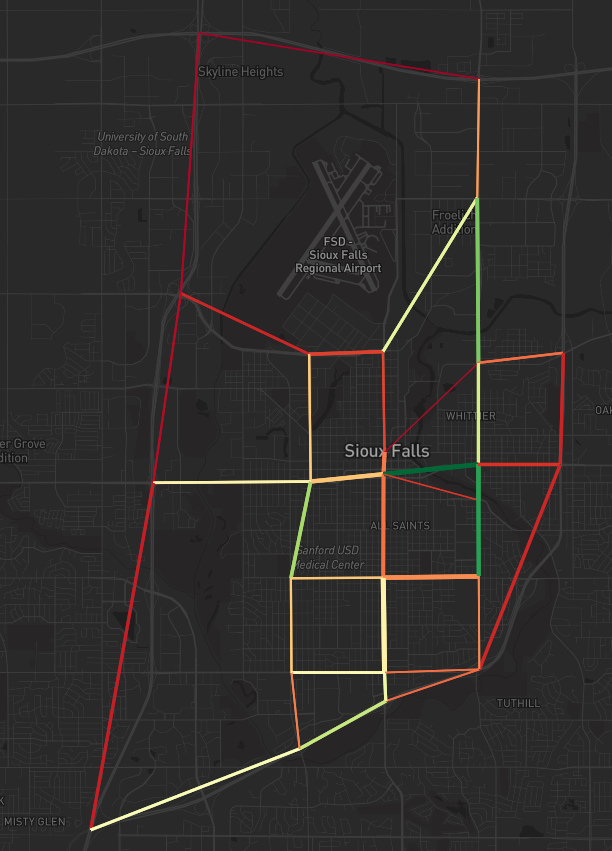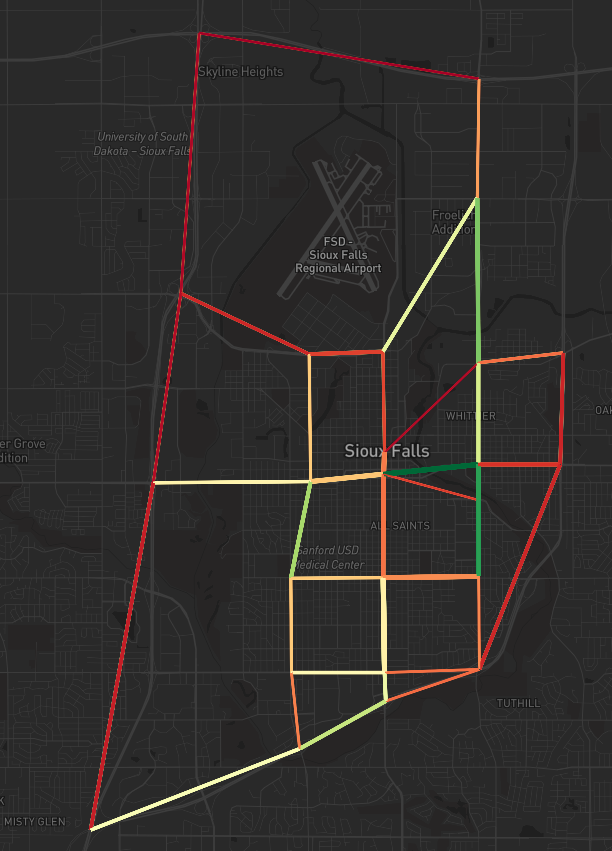